In [1]:
import osrm

This is different than the package `py-osrm`. Unfortunately, they both import as osrm. So if you want this to work again, you may have to install `python-osrm`. confusing.

First task is to figure out how to connect my OSRM engine

In [2]:
osrm.RequestConfig.host = 'http://localhost:5000'
osrm.RequestConfig.profile = 'car'

To run this, I need to have an OSRM instance running on the server. Do this in the terminal:

`docker run -t -i -p 5000:5000 -v "${PWD}:/data" ghcr.io/project-osrm/osrm-backend osrm-routed --algorithm mld /data/ireland-and-northern-ireland-latest.osrm`

Must be done AFTER processing the data using the bash script in the data directory

... Also I don't know how to turn it off? "the port is already allocated"

In [3]:
import geopandas as gpd

In [4]:
dublin_pubs = gpd.read_file('/home/dylan/projects/gsoc2025/spopt/notebooks/gsoc2025/data/dublin-pubs.geojson')

In [5]:
a = dublin_pubs.iloc[0]
b = dublin_pubs.iloc[1]

In [6]:
result = osrm.simple_route([float(a.geometry.x), float(a.geometry.y)], [float(b.geometry.x), float(b.geometry.y)], output='route', overview="full", geometry='wkt')

In [7]:
result[0].keys()
# data and metadata for the route

dict_keys(['legs', 'weight_name', 'geometry', 'weight', 'duration', 'distance'])

In [8]:
type(result[0]['geometry'])
# is a basic string, needs to be converted to a shapely geometry

str

In [10]:
linestring_str = result[0]['geometry']

In [11]:
from shapely import wkt
geometry = wkt.loads(linestring_str)

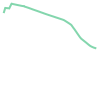

In [12]:
geometry

In [14]:
result[0]['duration']

339.3

In [15]:
result[0]['distance']

2831.9

In [16]:
import pandas, numpy

In [17]:
import sys
sys.path.insert(0, '/home/dylan/projects/gsoc2025/spopt/') # not the published spopt
import spopt

In [18]:
print(spopt.__file__)

/home/dylan/projects/gsoc2025/spopt/spopt/__init__.py


In [19]:
from spopt.route import engine, heuristic, utils

In [20]:
from spopt.route.heuristic import LastMile
from pyvrp import stop

In [21]:
trucks = pandas.DataFrame(
    [['big', 'lng',      2000,    280, .004,  .50, 5],
     ['big', 'electric', 2000,    480, .002,  .50, 5],
     ['med', 'lng',      800, 280*.66, .0001, .63, 10],
     ['med', 'electric', 800, 480*.66, .004,  .50, 10],
     ['smo', 'lng',      400, 280*0.4, .002,  .50, 20],
     ['smo', 'electric', 400, 480*0.4, .0001, .63, 20],
     ],
     columns = [
         'namesize', 'namefuel', 'capacity', 
         'fixed_cost', 'cost_per_meter', 'cost_per_minute', 'n_truck'
         ]
)

In [22]:
dublin_pubs = gpd.read_file('/home/dylan/projects/gsoc2025/spopt/notebooks/gsoc2025/data/dublin-pubs.geojson')

In [23]:
dublin_pubs.shape

(408, 9)

In [24]:
gdf = dublin_pubs
gdf = gdf.iloc[:407]

In [25]:
gdf['longitude'] = gdf.geometry.x
gdf['latitude'] = gdf.geometry.y

/home/dylan/mambaforge/envs/gsoc/lib/python3.11/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/dylan/mambaforge/envs/gsoc/lib/python3.11/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [26]:
depot = gdf.iloc[0] #unsure where the depot is?
clients = gdf.iloc[1:] 

In [28]:
clients['demand'] = 1
clients['supply'] = 1

/home/dylan/mambaforge/envs/gsoc/lib/python3.11/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
/home/dylan/mambaforge/envs/gsoc/lib/python3.11/site-packages/geopandas/geodataframe.py:1819: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [29]:
print('initializing model')
m = LastMile(
    depot_location=(depot.longitude.item(), depot.latitude.item()),
    depot_open=pandas.Timestamp("2030-01-02 07:00:00"),
    depot_close=pandas.Timestamp("2030-01-02 20:00:00"),
    depot_name=depot['name'],
)
print("adding clients")

m.add_clients(
    locations = clients.geometry, 
    delivery = clients.demand,
    pickup = clients.supply,
    time_windows=None,
    service_times=(numpy.log(clients.demand)**2).astype(int)
)
print("adding trucks")
m.add_trucks_from_frame(
    trucks, 
)
m.solve(stop=stop.MaxRuntime(60))
m.write_result("./guinness")

initializing model
adding clients
adding trucks


AttributeError: module 'osrm' has no attribute 'OSRM'

In [31]:
dir(osrm)

['AccessIsochrone',
 'DefaultRequestConfig',
 'Point',
 'RequestConfig',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '__version__',
 '_chain',
 'base64',
 'core',
 'extra',
 'match',
 'namedtuple',
 'nearest',
 'simple_route',
 'sys',
 'table',
 'trip']

In [ ]:
result[0]['duration']